In [1]:
## lets import necessary packages
## conda env compare_PSD
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import scipy.stats as stats
from statistics import mean


In [2]:
## Lets load the data

full_df_NO2 = pd.read_pickle("../NO/full_df_2021_NOX.pkl")
pd.set_option('display.max_columns', None)

## This the data cleaning. Keeping only the relevant features and removing the less than equal to zero target values

cols=[i for i in range(1,28)]
df1= full_df_NO2.drop(full_df_NO2.columns[cols], axis=1)
df2 = df1.drop(df1.columns[[2,3,4,5,6,9]], axis=1) 
j=[]
for i in range(4,72):
    j.append(i)
df3 = df2.drop(df2.columns[j], axis=1) 
df4 = df3.drop(df3.columns[[11,12,13,14,15,16,17,18]], axis=1) 
df4 = df4.drop(df4.columns[6], axis=1) 

df4.rename(columns={'pda': 'Average Pupil Diameter (mm)', 'pup_dis': 'Pupil Distance (mm)',
                    'pd_diff': 'Difference in Pupil Diameter (mm)', 'ECG.': 'ECG (V)',
                    'Resp.': 'Respiration Rate (brpm)',
                    'Temp.': r'Skin Temperature ($\mathrm{^o C})$','HR': 'Heart Rate (bpm)',
                    'NO2':r'$\mathrm{NO_2}$ (ppb)','SpO2':r'$\mathrm{SpO_2}$ (%)','GSR':r'GSR ($\mathrm{\mu S}$)'},
                                    inplace=True)
df_final = df4[df4[r'$\mathrm{NO_2}$ (ppb)'] >=0]

pd.options.mode.chained_assignment = None ## apparently this needs to be added to overcome an error i dont understand  

df_final[r'$\mathrm{SpO_2}$ (%)']=df_final[r'$\mathrm{SpO_2}$ (%)']*1000000 ## change the SpO2 to percentage
df_final[r'GSR ($\mathrm{\mu S}$)']=df_final[r'GSR ($\mathrm{\mu S}$)']*1000 ## convert kiloohms to ohms
df_final[r'GSR ($\mathrm{\mu S}$)']=1/df_final[r'GSR ($\mathrm{\mu S}$)']  ## convert ohms to siemans by taking the reciprocal
df_final[r'GSR ($\mathrm{\mu S}$)']=df_final[r'GSR ($\mathrm{\mu S}$)']*1000000 ## convert siemens to microsiemens

j=[]

for i in range(10,330):
    j.append(i)
df_final = df_final.drop(df_final.columns[j], axis=1) 
df_final

,$\mathrm{NO_2}$ (ppb),Average Pupil Diameter (mm),Pupil Distance (mm),Difference in Pupil Diameter (mm),ECG (V),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$
dateTime,,,,,,,,,,
2021-05-26 11:45:59.927799,12.4,4.155,65.24,-0.09,-0.000408,46.216525,100.0,84.0,0.080112,30.1875
2021-05-26 11:46:04.932462,12.6,3.525,65.22,0.11,-0.000526,44.886883,99.0,87.0,0.079841,30.1875
2021-05-26 11:46:09.932680,12.9,3.550,65.06,0.08,-0.000304,45.207832,98.0,88.0,0.079572,30.0625
2021-05-26 11:46:14.919361,13.1,3.395,65.17,0.11,-0.000389,44.520084,98.0,85.0,0.079706,30.0625
2021-05-26 11:46:19.922578,13.4,3.835,65.03,0.29,-0.000389,44.336684,99.0,82.0,0.079706,30.0625
...,...,...,...,...,...,...,...,...,...,...
2021-06-10 11:26:26.068698,16.4,2.750,65.90,0.02,-0.001450,28.931178,97.0,120.0,0.091122,29.3750
2021-06-10 11:26:31.056772,16.9,2.595,65.29,0.11,-0.001048,29.297976,96.0,120.0,0.091181,29.3750
2021-06-10 11:26:41.060407,14.9,2.615,66.04,0.05,-0.001223,27.463986,96.0,122.0,0.091682,29.4375


In [3]:
## lets load the new PSD dataframe

new_psd=pd.read_pickle('../PB_PSD/Entire_PSD_PB.pkl')
new_psd

,Fp1-delta (W/Hz),Fp2-delta (W/Hz),F3-delta (W/Hz),F4-delta (W/Hz),C3-delta (W/Hz),C4-delta (W/Hz),P3-delta (W/Hz),P4-delta (W/Hz),O1-delta (W/Hz),O2-delta (W/Hz),F7-delta (W/Hz),F8-delta (W/Hz),T7-delta (W/Hz),T8-delta (W/Hz),P7-delta (W/Hz),P8-delta (W/Hz),Fz-delta (W/Hz),Cz-delta (W/Hz),Pz-delta (W/Hz),Oz-delta (W/Hz),FC1-delta (W/Hz),FC2-delta (W/Hz),CP1-delta (W/Hz),CP2-delta (W/Hz),FC5-delta (W/Hz),FC6-delta (W/Hz),CP5-delta (W/Hz),CP6-delta (W/Hz),FT9-delta (W/Hz),FT10-delta (W/Hz),FCz-delta (W/Hz),AFz-delta (W/Hz),F1-delta (W/Hz),F2-delta (W/Hz),C1-delta (W/Hz),C2-delta (W/Hz),P1-delta (W/Hz),P2-delta (W/Hz),AF3-delta (W/Hz),AF4-delta (W/Hz),FC3-delta (W/Hz),FC4-delta (W/Hz),CP3-delta (W/Hz),CP4-delta (W/Hz),PO3-delta (W/Hz),PO4-delta (W/Hz),F5-delta (W/Hz),F6-delta (W/Hz),C5-delta (W/Hz),C6-delta (W/Hz),P5-delta (W/Hz),P6-delta (W/Hz),AF7-delta (W/Hz),AF8-delta (W/Hz),FT7-delta (W/Hz),FT8-delta (W/Hz),TP7-delta (W/Hz),TP8-delta (W/Hz),PO7-delta (W/Hz),PO8-delta (W/Hz),Fpz-delta (W/Hz),CPz-delta (W/Hz),POz-delta (W/Hz),TP10-delta (W/Hz),Fp1-theta (W/Hz),Fp2-theta (W/Hz),F3-theta (W/Hz),F4-theta (W/Hz),C3-theta (W/Hz),C4-theta (W/Hz),P3-theta (W/Hz),P4-theta (W/Hz),O1-theta (W/Hz),O2-theta (W/Hz),F7-theta (W/Hz),F8-theta (W/Hz),T7-theta (W/Hz),T8-theta (W/Hz),P7-theta (W/Hz),P8-theta (W/Hz),Fz-theta (W/Hz),Cz-theta (W/Hz),Pz-theta (W/Hz),Oz-theta (W/Hz),FC1-theta (W/Hz),FC2-theta (W/Hz),CP1-theta (W/Hz),CP2-theta (W/Hz),FC5-theta (W/Hz),FC6-theta (W/Hz),CP5-theta (W/Hz),CP6-theta (W/Hz),FT9-theta (W/Hz),FT10-theta (W/Hz),FCz-theta (W/Hz),AFz-theta (W/Hz),F1-theta (W/Hz),F2-theta (W/Hz),C1-theta (W/Hz),C2-theta (W/Hz),P1-theta (W/Hz),P2-theta (W/Hz),AF3-theta (W/Hz),AF4-theta (W/Hz),FC3-theta (W/Hz),FC4-theta (W/Hz),CP3-theta (W/Hz),CP4-theta (W/Hz),PO3-theta (W/Hz),PO4-theta (W/Hz),F5-theta (W/Hz),F6-theta (W/Hz),C5-theta (W/Hz),C6-theta (W/Hz),P5-theta (W/Hz),P6-theta (W/Hz),AF7-theta (W/Hz),AF8-theta (W/Hz),FT7-theta (W/Hz),FT8-theta (W/Hz),TP7-theta (W/Hz),TP8-theta (W/Hz),PO7-theta (W/Hz),PO8-theta (W/Hz),Fpz-theta (W/Hz),CPz-theta (W/Hz),POz-theta (W/Hz),TP10-theta (W/Hz),Fp1-alpha (W/Hz),Fp2-alpha (W/Hz),F3-alpha (W/Hz),F4-alpha (W/Hz),C3-alpha (W/Hz),C4-alpha (W/Hz),P3-alpha (W/Hz),P4-alpha (W/Hz),O1-alpha (W/Hz),O2-alpha (W/Hz),F7-alpha (W/Hz),F8-alpha (W/Hz),T7-alpha (W/Hz),T8-alpha (W/Hz),P7-alpha (W/Hz),P8-alpha (W/Hz),Fz-alpha (W/Hz),Cz-alpha (W/Hz),Pz-alpha (W/Hz),Oz-alpha (W/Hz),FC1-alpha (W/Hz),FC2-alpha (W/Hz),CP1-alpha (W/Hz),CP2-alpha (W/Hz),FC5-alpha (W/Hz),FC6-alpha (W/Hz),CP5-alpha (W/Hz),CP6-alpha (W/Hz),FT9-alpha (W/Hz),FT10-alpha (W/Hz),FCz-alpha (W/Hz),AFz-alpha (W/Hz),F1-alpha (W/Hz),F2-alpha (W/Hz),C1-alpha (W/Hz),C2-alpha (W/Hz),P1-alpha (W/Hz),P2-alpha (W/Hz),AF3-alpha (W/Hz),AF4-alpha (W/Hz),FC3-alpha (W/Hz),FC4-alpha (W/Hz),CP3-alpha (W/Hz),CP4-alpha (W/Hz),PO3-alpha (W/Hz),PO4-alpha (W/Hz),F5-alpha (W/Hz),F6-alpha (W/Hz),C5-alpha (W/Hz),C6-alpha (W/Hz),P5-alpha (W/Hz),P6-alpha (W/Hz),AF7-alpha (W/Hz),AF8-alpha (W/Hz),FT7-alpha (W/Hz),FT8-alpha (W/Hz),TP7-alpha (W/Hz),TP8-alpha (W/Hz),PO7-alpha (W/Hz),PO8-alpha (W/Hz),Fpz-alpha (W/Hz),CPz-alpha (W/Hz),POz-alpha (W/Hz),TP10-alpha (W/Hz),Fp1-beta (W/Hz),Fp2-beta (W/Hz),F3-beta (W/Hz),F4-beta (W/Hz),C3-beta (W/Hz),C4-beta (W/Hz),P3-beta (W/Hz),P4-beta (W/Hz),O1-beta (W/Hz),O2-beta (W/Hz),F7-beta (W/Hz),F8-beta (W/Hz),T7-beta (W/Hz),T8-beta (W/Hz),P7-beta (W/Hz),P8-beta (W/Hz),Fz-beta (W/Hz),Cz-beta (W/Hz),Pz-beta (W/Hz),Oz-beta (W/Hz),FC1-beta (W/Hz),FC2-beta (W/Hz),CP1-beta (W/Hz),CP2-beta (W/Hz),FC5-beta (W/Hz),FC6-beta (W/Hz),CP5-beta (W/Hz),CP6-beta (W/Hz),FT9-beta (W/Hz),FT10-beta (W/Hz),FCz-beta (W/Hz),AFz-beta (W/Hz),F1-beta (W/Hz),F2-beta (W/Hz),C1-beta (W/Hz),C2-beta (W/Hz),P1-beta (W/Hz),P2-beta (W/Hz),AF3-beta (W/Hz),AF4-beta (W/Hz),FC3-beta (W/Hz),FC4-beta (W/Hz),CP3-beta (W/Hz),CP4-beta (W/Hz),PO3-beta (W/Hz),PO4-beta (W/Hz),F5-beta (W/Hz),F6-beta (W/Hz),C5-beta (W/Hz),C6-beta (W/Hz),P5-beta (W/Hz),P6-beta (W/Hz),AF7-beta (W/Hz),

In [4]:
## lets merge it

tol_2 = pd.Timedelta('1s')
full_df = pd.merge_asof(left=df_final, right=new_psd, right_index=True, left_index=True,
                                               direction='nearest', tolerance=tol_2)
df_final=full_df
df_final

,$\mathrm{NO_2}$ (ppb),Average Pupil Diameter (mm),Pupil Distance (mm),Difference in Pupil Diameter (mm),ECG (V),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$,Fp1-delta (W/Hz),Fp2-delta (W/Hz),F3-delta (W/Hz),F4-delta (W/Hz),C3-delta (W/Hz),C4-delta (W/Hz),P3-delta (W/Hz),P4-delta (W/Hz),O1-delta (W/Hz),O2-delta (W/Hz),F7-delta (W/Hz),F8-delta (W/Hz),T7-delta (W/Hz),T8-delta (W/Hz),P7-delta (W/Hz),P8-delta (W/Hz),Fz-delta (W/Hz),Cz-delta (W/Hz),Pz-delta (W/Hz),Oz-delta (W/Hz),FC1-delta (W/Hz),FC2-delta (W/Hz),CP1-delta (W/Hz),CP2-delta (W/Hz),FC5-delta (W/Hz),FC6-delta (W/Hz),CP5-delta (W/Hz),CP6-delta (W/Hz),FT9-delta (W/Hz),FT10-delta (W/Hz),FCz-delta (W/Hz),AFz-delta (W/Hz),F1-delta (W/Hz),F2-delta (W/Hz),C1-delta (W/Hz),C2-delta (W/Hz),P1-delta (W/Hz),P2-delta (W/Hz),AF3-delta (W/Hz),AF4-delta (W/Hz),FC3-delta (W/Hz),FC4-delta (W/Hz),CP3-delta (W/Hz),CP4-delta (W/Hz),PO3-delta (W/Hz),PO4-delta (W/Hz),F5-delta (W/Hz),F6-delta (W/Hz),C5-delta (W/Hz),C6-delta (W/Hz),P5-delta (W/Hz),P6-delta (W/Hz),AF7-delta (W/Hz),AF8-delta (W/Hz),FT7-delta (W/Hz),FT8-delta (W/Hz),TP7-delta (W/Hz),TP8-delta (W/Hz),PO7-delta (W/Hz),PO8-delta (W/Hz),Fpz-delta (W/Hz),CPz-delta (W/Hz),POz-delta (W/Hz),TP10-delta (W/Hz),Fp1-theta (W/Hz),Fp2-theta (W/Hz),F3-theta (W/Hz),F4-theta (W/Hz),C3-theta (W/Hz),C4-theta (W/Hz),P3-theta (W/Hz),P4-theta (W/Hz),O1-theta (W/Hz),O2-theta (W/Hz),F7-theta (W/Hz),F8-theta (W/Hz),T7-theta (W/Hz),T8-theta (W/Hz),P7-theta (W/Hz),P8-theta (W/Hz),Fz-theta (W/Hz),Cz-theta (W/Hz),Pz-theta (W/Hz),Oz-theta (W/Hz),FC1-theta (W/Hz),FC2-theta (W/Hz),CP1-theta (W/Hz),CP2-theta (W/Hz),FC5-theta (W/Hz),FC6-theta (W/Hz),CP5-theta (W/Hz),CP6-theta (W/Hz),FT9-theta (W/Hz),FT10-theta (W/Hz),FCz-theta (W/Hz),AFz-theta (W/Hz),F1-theta (W/Hz),F2-theta (W/Hz),C1-theta (W/Hz),C2-theta (W/Hz),P1-theta (W/Hz),P2-theta (W/Hz),AF3-theta (W/Hz),AF4-theta (W/Hz),FC3-theta (W/Hz),FC4-theta (W/Hz),CP3-theta (W/Hz),CP4-theta (W/Hz),PO3-theta (W/Hz),PO4-theta (W/Hz),F5-theta (W/Hz),F6-theta (W/Hz),C5-theta (W/Hz),C6-theta (W/Hz),P5-theta (W/Hz),P6-theta (W/Hz),AF7-theta (W/Hz),AF8-theta (W/Hz),FT7-theta (W/Hz),FT8-theta (W/Hz),TP7-theta (W/Hz),TP8-theta (W/Hz),PO7-theta (W/Hz),PO8-theta (W/Hz),Fpz-theta (W/Hz),CPz-theta (W/Hz),POz-theta (W/Hz),TP10-theta (W/Hz),Fp1-alpha (W/Hz),Fp2-alpha (W/Hz),F3-alpha (W/Hz),F4-alpha (W/Hz),C3-alpha (W/Hz),C4-alpha (W/Hz),P3-alpha (W/Hz),P4-alpha (W/Hz),O1-alpha (W/Hz),O2-alpha (W/Hz),F7-alpha (W/Hz),F8-alpha (W/Hz),T7-alpha (W/Hz),T8-alpha (W/Hz),P7-alpha (W/Hz),P8-alpha (W/Hz),Fz-alpha (W/Hz),Cz-alpha (W/Hz),Pz-alpha (W/Hz),Oz-alpha (W/Hz),FC1-alpha (W/Hz),FC2-alpha (W/Hz),CP1-alpha (W/Hz),CP2-alpha (W/Hz),FC5-alpha (W/Hz),FC6-alpha (W/Hz),CP5-alpha (W/Hz),CP6-alpha (W/Hz),FT9-alpha (W/Hz),FT10-alpha (W/Hz),FCz-alpha (W/Hz),AFz-alpha (W/Hz),F1-alpha (W/Hz),F2-alpha (W/Hz),C1-alpha (W/Hz),C2-alpha (W/Hz),P1-alpha (W/Hz),P2-alpha (W/Hz),AF3-alpha (W/Hz),AF4-alpha (W/Hz),FC3-alpha (W/Hz),FC4-alpha (W/Hz),CP3-alpha (W/Hz),CP4-alpha (W/Hz),PO3-alpha (W/Hz),PO4-alpha (W/Hz),F5-alpha (W/Hz),F6-alpha (W/Hz),C5-alpha (W/Hz),C6-alpha (W/Hz),P5-alpha (W/Hz),P6-alpha (W/Hz),AF7-alpha (W/Hz),AF8-alpha (W/Hz),FT7-alpha (W/Hz),FT8-alpha (W/Hz),TP7-alpha (W/Hz),TP8-alpha (W/Hz),PO7-alpha (W/Hz),PO8-alpha (W/Hz),Fpz-alpha (W/Hz),CPz-alpha (W/Hz),POz-alpha (W/Hz),TP10-alpha (W/Hz),Fp1-beta (W/Hz),Fp2-beta (W/Hz),F3-beta (W/Hz),F4-beta (W/Hz),C3-beta (W/Hz),C4-beta (W/Hz),P3-beta (W/Hz),P4-beta (W/Hz),O1-beta (W/Hz),O2-beta (W/Hz),F7-beta (W/Hz),F8-beta (W/Hz),T7-beta (W/Hz),T8-beta (W/Hz),P7-beta (W/Hz),P8-beta (W/Hz),Fz-beta (W/Hz),Cz-beta (W/Hz),Pz-beta (W/Hz),Oz-beta (W/Hz),FC1-beta (W/Hz),FC2-beta (W/Hz),CP1-beta (W/Hz),CP2-beta (W/Hz),FC5-beta (W/Hz),FC6-beta (W/Hz),CP5-beta (W/Hz),CP6-beta (W/Hz),FT9-beta (W/Hz),FT10-beta (W/Hz),FCz-beta (W/Hz),AFz-beta (W/Hz),F1-beta (W/Hz),F2-beta (W/Hz),C1-beta (W/Hz),C2-beta (W/Hz),P1-beta (W/Hz),P2-beta (W/Hz),AF

In [5]:
## Lets create a Train-Test set

features=df_final.drop(r"$\mathrm{NO_2}$ (ppb)",axis=1)
target=df_final[r"$\mathrm{NO_2}$ (ppb)"].copy()

#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)

In [6]:
## lets optimize the hyperparameters

param_grid=[{'n_estimators':[80,90,100,110,120], 'max_features':[250, 275, 300, 325]},]

In [7]:
## Lets now train the model using Random Forest Regressor 

forest_reg=RandomForestRegressor(n_jobs=-1)
grid_search=GridSearchCV(forest_reg,param_grid,cv=3,scoring="neg_mean_squared_error",return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid=[{'max_features': [250, 275, 300, 325],
                          'n_estimators': [80, 90, 100, 110, 120]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [8]:
grid_search.best_estimator_

RandomForestRegressor(max_features=250, n_jobs=-1)

In [9]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [10]:
## Lets now train the model using Random Forest Regressor 

final_model.fit(X_train,y_train)

## The train prediction
train_prediction_RF=final_model.predict(X_train)
RF_mse=mean_squared_error(y_train,train_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_train=RF_rmse

print('The train RMSE for NO2 is:::', '%.2f' % RF_rmse_train)

The train RMSE for NO2 is::: 2.85


In [11]:
## The test prediction

test_prediction_RF=final_model.predict(X_test)
RF_mse=mean_squared_error(y_test,test_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_test=RF_rmse

print('The test RMSE for NO2 is:::', '%.2f' % RF_rmse_test)

The test RMSE for NO2 is::: 6.85


In [12]:
### The correlation values

#from scipy.stats import pearsonr

## The train correlation
train_r_sq=pearsonr(y_train,train_prediction_RF)[0]
correlation_train=int(train_r_sq*100)/100 ## display only two digits without rounding
print(correlation_train)

## The test correlation
test_r_sq=pearsonr(y_test,test_prediction_RF)[0]
correlation_test=int(test_r_sq*100)/100 ## display only two digits without rounding
print(correlation_test)

0.96
0.45


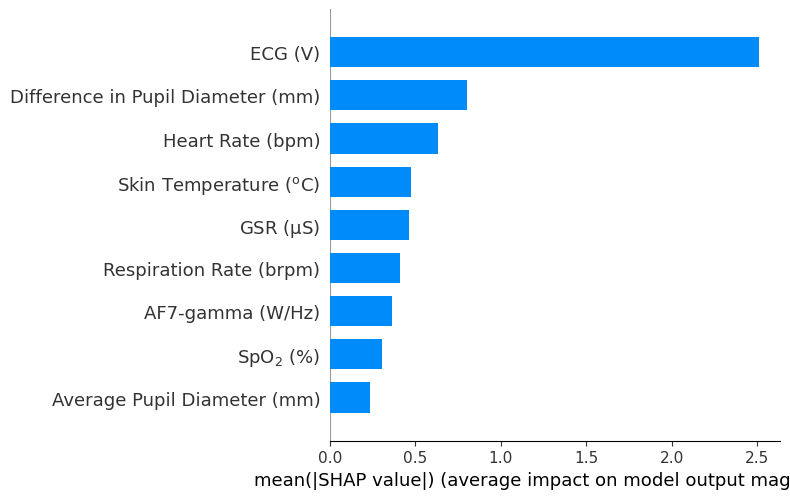

In [13]:
## displaying the feature importance using shap values

shap_values = shap.TreeExplainer(final_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=9)

In [14]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction_RF, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction_RF, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])
sns_df

,Actual,Estimated,Label
0,11.7,12.920,Train
1,11.3,11.397,Train
2,7.3,7.049,Train
3,11.8,11.855,Train
4,16.0,16.276,Train
...,...,...,...
112,13.4,13.092,Test
113,5.5,5.992,Test
114,12.0,10.572,Test
115,16.0,15.533,Test


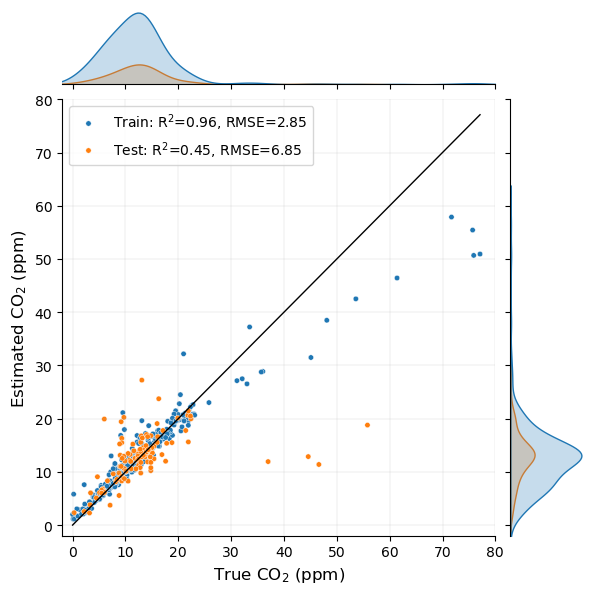

In [15]:
## scatter plot in seaborn

g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',
                 xlim=[-2, 80], ylim=[-2, 80], s=15)
plt.grid(axis='both',linewidth=0.15)


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1)

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()


g.ax_joint.legend(handles=handles, labels=[ f'Train: R$^2$={correlation_train}, RMSE={RF_rmse_train:.2f}', 
                                               f'Test: R$^2$={correlation_test}, RMSE={RF_rmse_test:.2f}'], title=None)


g.set_axis_labels(r'True $\mathrm{CO_2}$ (ppm)', r'Estimated $\mathrm{CO_2}$ (ppm)',fontsize=12)
plt.show()

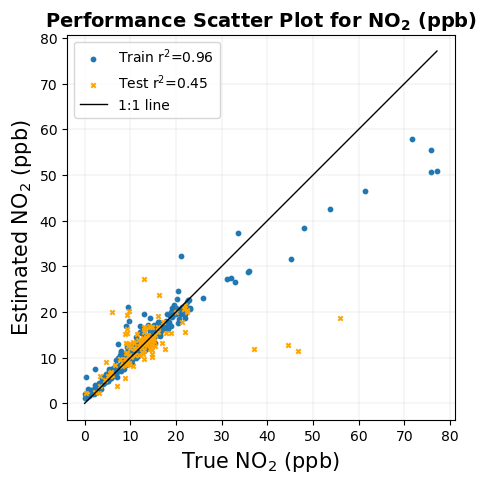

In [16]:
## optional scatter plot

import matplotlib as mpl
mpl.rcParams['mathtext.default']='regular'

plt.figure(figsize=(5,5))
plt.scatter(y_train, train_prediction_RF,s=10,c='C0',label='Train $r^2$={}'.format(correlation_train))
plt.scatter(y_test, test_prediction_RF,marker='x',s=10,c='orange',label='Test $r^2$={}'.format(correlation_test))


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))
plt.plot([p1, p2], [p1, p2], 'black',label='1:1 line',linewidth=1)
plt.xlabel('True NO$_2$ (ppb)', fontsize=15)
plt.ylabel('Estimated NO$_2$ (ppb)', fontsize=15)
plt.axis('equal')
plt.title("Performance Scatter Plot for NO$_2$ (ppb)", fontsize=14,fontweight="bold")
plt.legend()
plt.grid(axis='both',linewidth=0.15)
plt.show()

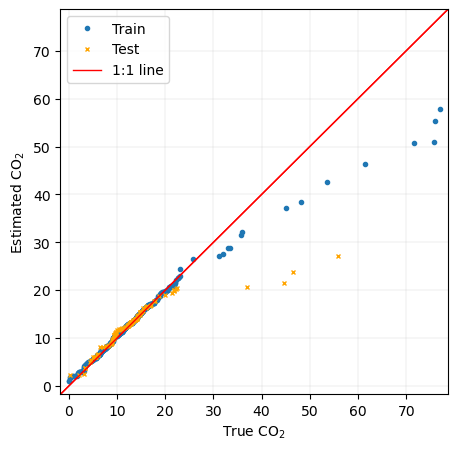

In [17]:
## Lets plot the quantile quantile 
fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction_RF, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train')
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction_RF, fit=False)

qqq = pp_yy.qqplot(xlabel=r'True $\mathrm{CO_2}$',ylabel=r'Estimated $\mathrm{CO_2}$',
                    marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange', markerfacecolor = 'orange', label='Test')
sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()

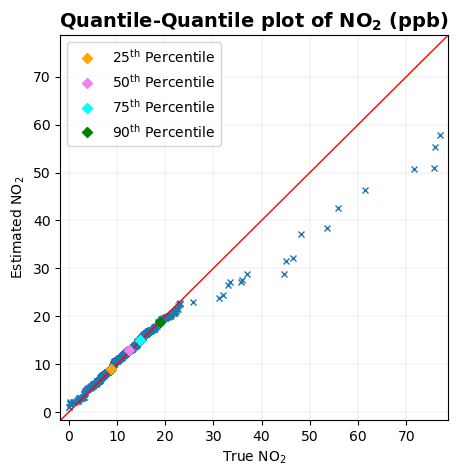

In [18]:
## optinal. QQ plot of the entire distribution

import statsmodels.api as sm
import scipy.stats as stats

all_preds_NO=np.concatenate((train_prediction_RF,test_prediction_RF)) ## the list of all predictions and target values

preds=np.sort(all_preds_NO)
tars=target.sort_values()

plt.rc("figure", figsize=(5,5)) ## to make same figure size in statsmodels.api

pp_x = sm.ProbPlot(preds, fit=False)
pp_y = sm.ProbPlot(tars, fit=False)
qq = pp_x.qqplot(xlabel='True NO$_2$',ylabel='Estimated NO$_2$',marker='x',markersize=4,other=pp_y)

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1)
tars_25=np.percentile(tars,25)  ## for the percentiles                                                        
tars_50=np.percentile(tars,50)
tars_75=np.percentile(tars,75)
tars_90=np.percentile(tars,90)


preds_25=np.percentile(preds,25)
preds_50=np.percentile(preds,50)
preds_75=np.percentile(preds,75)  
preds_90=np.percentile(tars,90)  ## end of percentiles

plt.plot(tars_25,preds_25,marker="D",markersize=5,color="orange",linestyle ='None',label=r"$\mathrm{25^{th}}$ Percentile")
plt.plot(tars_50,preds_50,marker="D",markersize=5,color="violet",linestyle ='None',label=r"$\mathrm{50^{th}}$ Percentile")
plt.plot(tars_75,preds_75,marker="D",markersize=5,color="Cyan",linestyle ='None',label=r"$\mathrm{75^{th}}$ Percentile")
plt.plot(tars_90,preds_90,marker="D",markersize=5,color="Green",linestyle ='None',label=r"$\mathrm{90^{th}}$ Percentile")


plt.grid(axis='both',linewidth=0.15)

plt. title('Quantile-Quantile plot of NO$_2$ (ppb) ',fontsize=14,fontweight="bold")

plt.legend()
plt.show()

In [19]:
## lets calculate the average values RMSE

j_train=[]
j_test=[]
k_train=[]
k_test=[]
for i in range(0,50):
      
    X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)
    final_model.fit(X_train,y_train)

    train_prediction=final_model.predict(X_train)
    mse_train=mean_squared_error(y_train,train_prediction)
    rmse_train=np.sqrt(mse_train)
    j_train.append(rmse_train)
    
    test_prediction=final_model.predict(X_test)

    mse_test=mean_squared_error(y_test,test_prediction)
    rmse_test=np.sqrt(mse_test)
    j_test.append(rmse_test)

## lets calculate the average correlation    
  
    train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
    correlation_train=int(train_r_sq*100)/100 ## display 
    k_train.append(correlation_train)
    
    test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
    correlation_test=int(test_r_sq*100)/100
    k_test.append(correlation_test)

average_train_rmse=mean(j_train)
average_test_rmse=mean(j_test)
    
average_train_rsq=mean(k_train)
average_test_rsq=mean(k_test)

print('The average train RMSE for NO2 is:::', '%.2f' % average_train_rmse)
print('The average test RMSE for NO2 is:::', '%.2f' % average_test_rmse)

print('The average train r square for NO2 is:::', '%.2f' % average_train_rsq)
print('The average test r square for NO2 is:::', '%.2f' % average_test_rsq)

The average train RMSE for NO2 is::: 2.76
The average test RMSE for NO2 is::: 6.97
The average train r square for NO2 is::: 0.93
The average test r square for NO2 is::: 0.32


In [20]:
print('The test RMSE error in each of the trail is:::', j_test)

The test RMSE error in each of the trail is::: [3.9517991120782194, 8.605279700157846, 7.709253286753279, 9.25236698983184, 5.490394601514712, 5.125425362377168, 7.259731612495748, 6.585730242009068, 6.1191678097402, 5.289203357202872, 4.9707732162633755, 6.786262523229413, 4.526619566614219, 6.403258288512319, 6.04221625369452, 7.5425777542884616, 6.045511279658538, 7.731196498546993, 6.187438722134624, 8.181424677932553, 8.583313789372818, 6.873881167080596, 7.834016872522958, 10.248715588068986, 6.862634011270715, 6.284502617176569, 8.06188838295007, 6.116075345552785, 7.849964128613125, 5.498199923766814, 6.881803565653362, 4.77884986699541, 4.6027469436577135, 6.643163785838047, 6.139019110658121, 6.856692960197894, 4.8898642684743905, 6.725859089791168, 5.411059424365724, 8.459785008684463, 7.623215114058745, 8.212435493508776, 6.02379894756488, 8.124548442415886, 6.963357379271365, 9.415751775388223, 10.579427810775913, 9.36026901277164, 8.087215955724808, 8.850573153491197]


In [21]:
test_rmse=pd.DataFrame(j_test, columns=['Test RMSE for NO$_2$ (ppb)'])
test_rmse.head()

,Test RMSE for NO$_2$ (ppb)
0,3.951799
1,8.605280
2,7.709253
3,9.252367
4,5.490395


In [22]:
print('The r^2 in each of the trail in test set is:::', k_test)

The r^2 in each of the trail in test set is::: [0.53, 0.19, 0.22, 0.22, 0.37, 0.32, 0.31, 0.45, 0.29, 0.39, 0.48, 0.2, 0.46, 0.32, 0.34, 0.24, 0.36, 0.38, 0.47, 0.23, 0.21, 0.26, 0.34, 0.2, 0.26, 0.36, 0.27, 0.29, 0.35, 0.47, 0.29, 0.43, 0.49, 0.29, 0.25, 0.32, 0.35, 0.37, 0.44, 0.37, 0.23, 0.29, 0.39, 0.42, 0.27, 0.19, 0.2, 0.13, 0.29, 0.2]


In [23]:
test_r2=pd.DataFrame(k_test, columns=['Test R$^2$ for NO$_2$ (ppb)'])
test_r2.head()

,Test R$^2$ for NO$_2$ (ppb)
0,0.53
1,0.19
2,0.22
3,0.22
4,0.37


In [24]:
combined_NO2_PB=pd.concat([test_rmse,test_r2], axis=1)
combined_NO2_PB

,Test RMSE for NO$_2$ (ppb),Test R$^2$ for NO$_2$ (ppb)
0,3.951799,0.53
1,8.605280,0.19
2,7.709253,0.22
3,9.252367,0.22
4,5.490395,0.37
5,5.125425,0.32
6,7.259732,0.31
7,6.585730,0.45
8,6.119168,0.29
9,5.289203,0.39
